In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [2]:
import tensorflow as tf

def reshape_square(arr, k=25):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros(k*k)
    a = arr.reshape(-1)
    x[:a.shape[0]] = a
    return x.reshape(k, k, 1)
    
X = np.stack(train_df.cens_slice.apply(reshape_square))

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

tf.config.list_physical_devices('GPU')
def get_compiled_model(input_shape=(25, 25, 1), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
test_dataset

<TensorSliceDataset shapes: ((25, 25, 1), (397,)), types: (tf.float64, tf.int32)>

In [6]:
np.random.uniform(size=100)

array([0.14009247, 0.44758779, 0.11341252, 0.90484282, 0.80928323,
       0.17205945, 0.32660688, 0.42423805, 0.07691648, 0.96372409,
       0.25139674, 0.23020336, 0.10183207, 0.75271075, 0.66294736,
       0.05224667, 0.34644137, 0.62732588, 0.93744851, 0.86245542,
       0.13717593, 0.53907593, 0.63028656, 0.35624   , 0.28983044,
       0.89422294, 0.41920528, 0.26505981, 0.08905806, 0.88042319,
       0.06902954, 0.4961369 , 0.17869224, 0.20841709, 0.34677531,
       0.64282685, 0.76764489, 0.19284024, 0.07125817, 0.16475455,
       0.64153125, 0.24336085, 0.2068749 , 0.87175859, 0.60852436,
       0.32433613, 0.45774759, 0.58470478, 0.34626952, 0.98003575,
       0.80201956, 0.12912947, 0.72333938, 0.20627572, 0.75945977,
       0.34552769, 0.25195099, 0.93693392, 0.88717159, 0.13204305,
       0.06631441, 0.62729898, 0.1175419 , 0.07743469, 0.23390558,
       0.78497499, 0.07503026, 0.13080363, 0.98720941, 0.04394664,
       0.83823952, 0.32812802, 0.41361109, 0.96250122, 0.01676

In [8]:
# https://github.com/tensorpack/tensorpack/blob/5845ead80e3d77c89e2f1e9d5e0691324a8354cc/examples/ResNet/cifar10-preact18-mixup.py#L101-L118

def _mixup(x_in, y_in):
    n = x_in.shape[0]
    # draw from uniform instead of beta(alpha, alpha, BATCH_SIZE)
    w = np.random.uniform(0.3, 0.7, size=n)
    x_weight = w.reshape(n, 1, 1, 1)
    index = np.random.permutation(n)

    x = x_in * x_weight + x_in[index] * (1-x_weight)
    y = y_in + y_in[index]
    return x, y

@tf.function(input_signature=[
    tf.TensorSpec(None, tf.float64), 
    tf.TensorSpec(None, tf.int32), 
])
def mixup(x_in, y_in):
    x, y = tf.numpy_function(_mixup, [x_in, y_in], [tf.float64, tf.int32])
    return tf.data.Dataset.from_tensor_slices((
        tf.reshape(x, [-1, 25,25,1]), 
        tf.reshape(y, [-1, 397])
    ))

def add_mixup(dataset, batch_size=1024):
    return (
        dataset
        .window(batch_size)
        .flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(batch_size), y.batch(batch_size))))
        .map(mixup)
        .flat_map(lambda x: x)
        .batch(batch_size)
    )

add_mixup(test_dataset)

<BatchDataset shapes: ((None, 25, 25, 1), (None, 397)), types: (tf.float64, tf.int32)>

In [9]:
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         7

In [120]:
history = model.fit(add_mixup(train_dataset), epochs=50, validation_data=test_dataset.batch(1024))

Epoch 1/50
432/432 [==============================] - 33s 75ms/step - loss: 0.0918 - accuracy: 0.0136 - f1_score: 6.1367e-04 - val_loss: 0.0174 - val_accuracy: 0.0175 - val_f1_score: 7.6621e-04
Epoch 2/50
432/432 [==============================] - 33s 76ms/step - loss: 0.0303 - accuracy: 0.0192 - f1_score: 0.0010 - val_loss: 0.0173 - val_accuracy: 0.0210 - val_f1_score: 9.3144e-04
Epoch 3/50
432/432 [==============================] - 33s 77ms/step - loss: 0.0302 - accuracy: 0.0231 - f1_score: 0.0015 - val_loss: 0.0174 - val_accuracy: 0.0230 - val_f1_score: 0.0019
Epoch 4/50
432/432 [==============================] - 31s 72ms/step - loss: 0.0301 - accuracy: 0.0272 - f1_score: 0.0027 - val_loss: 0.0170 - val_accuracy: 0.0251 - val_f1_score: 0.0024
Epoch 5/50
432/432 [==============================] - 31s 72ms/step - loss: 0.0300 - accuracy: 0.0287 - f1_score: 0.0033 - val_loss: 0.0170 - val_accuracy: 0.0285 - val_f1_score: 0.0039
Epoch 6/50
432/432 [==============================] - 31s 

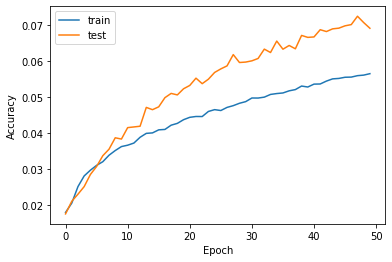

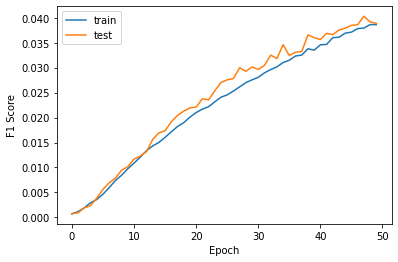

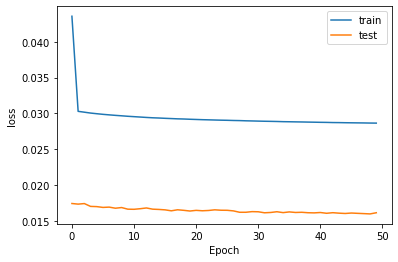

5914/5914 - 26s - loss: 0.0161 - accuracy: 0.0690 - f1_score: 0.0389


[0.01613907516002655,
 0.06904423236846924,
 array([0.        , 0.00914634, 0.12081985, 0.        , 0.01282051,
        0.        , 0.        , 0.        , 0.00469484, 0.10990368,
        0.        , 0.        , 0.01992337, 0.        , 0.04623514,
        0.        , 0.        , 0.        , 0.        , 0.01156069,
        0.03292181, 0.        , 0.09079755, 0.12918994, 0.        ,
        0.01058201, 0.0041841 , 0.0700637 , 0.        , 0.04456094,
        0.        , 0.00324149, 0.0557047 , 0.06451613, 0.        ,
        0.02830189, 0.04577465, 0.02514286, 0.17944534, 0.        ,
        0.06185567, 0.04928806, 0.03100775, 0.02272727, 0.        ,
        0.05291006, 0.07741936, 0.05513016, 0.03483607, 0.12176106,
        0.02302632, 0.        , 0.01666667, 0.        , 0.20549928,
        0.09024134, 0.        , 0.08053692, 0.03611111, 0.05084746,
        0.02392681, 0.17339902, 0.03      , 0.        , 0.01355932,
        0.0472441 , 0.0802213 , 0.        , 0.00815217, 0.        ,
    

In [121]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)